In [1]:
import polars as pl
import polars.selectors as cs
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import os
import sys
import polars as pl
import numpy as np

import matplotlib.pyplot as plt

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
filter = '1h'

In [2]:
df = pl.read_parquet(os.path.join(DATA_DIRECTORY, "output", "side-by-side", "1_min_sbs_period_acropolis.parquet")) \
    .with_columns(diff = pl.col("gmp343_corrected") - pl.col("picarro_corrected")) \
    .group_by_dynamic("datetime", every=filter, group_by=["system_id", "system_name"]) \
            .agg(cs.numeric().mean())

In [3]:
#df = df.filter(pl.col("gmp343_temperature") > 32)

In [4]:
system_ids = df["system_id"].unique().to_list()
system_ids

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [5]:
def plot_scatter_with_trendline(df, x_col_name, y_col_name="diff", max_col=5, max_row=4, x_title="x_name", y_title="CO₂ hourly mean difference (ppm)", title_text="title_name"):
    system_ids = df.select("system_id").unique().to_series().sort().to_list()
    num_systems = len(system_ids)
    
    fig, axes = plt.subplots(max_row, max_col, figsize=(5 * max_col, 5 * max_row), sharey=True)
    fig.suptitle(title_text, fontsize=16)
    
    axes = np.array(axes).reshape(max_row, max_col)  # Ensure correct shape
    
    for idx, system_id in enumerate(system_ids):
        if idx >= max_row * max_col:
            break
        row, col = divmod(idx, max_col)
        
        ax = axes[row, col]
        df_plot = df.filter(pl.col("system_id") == system_id)
        
        x = df_plot.select(x_col_name).to_numpy().flatten().reshape(-1, 1)
        y = df_plot.select(y_col_name).to_numpy().flatten().reshape(-1, 1)
        
        # Scatter plot
        ax.scatter(x, y, label=f"MC-{int(system_id)}", alpha=0.5)
        
        # Fit linear regression
        if len(x) > 1:
            model = LinearRegression()
            model.fit(x, y)
            y_pred = model.predict(x)
            r2 = r2_score(y, y_pred)
            
            # Plot trendline
            ax.plot(x, y_pred, color='red', label=f"R²={r2:.2f}")
        
        ax.set_title(f"System: {int(system_id)}")
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        ax.legend()
    
    # Hide unused subplots
    for idx in range(num_systems, max_row * max_col):
        row, col = divmod(idx, max_col)
        fig.delaxes(axes[row, col])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

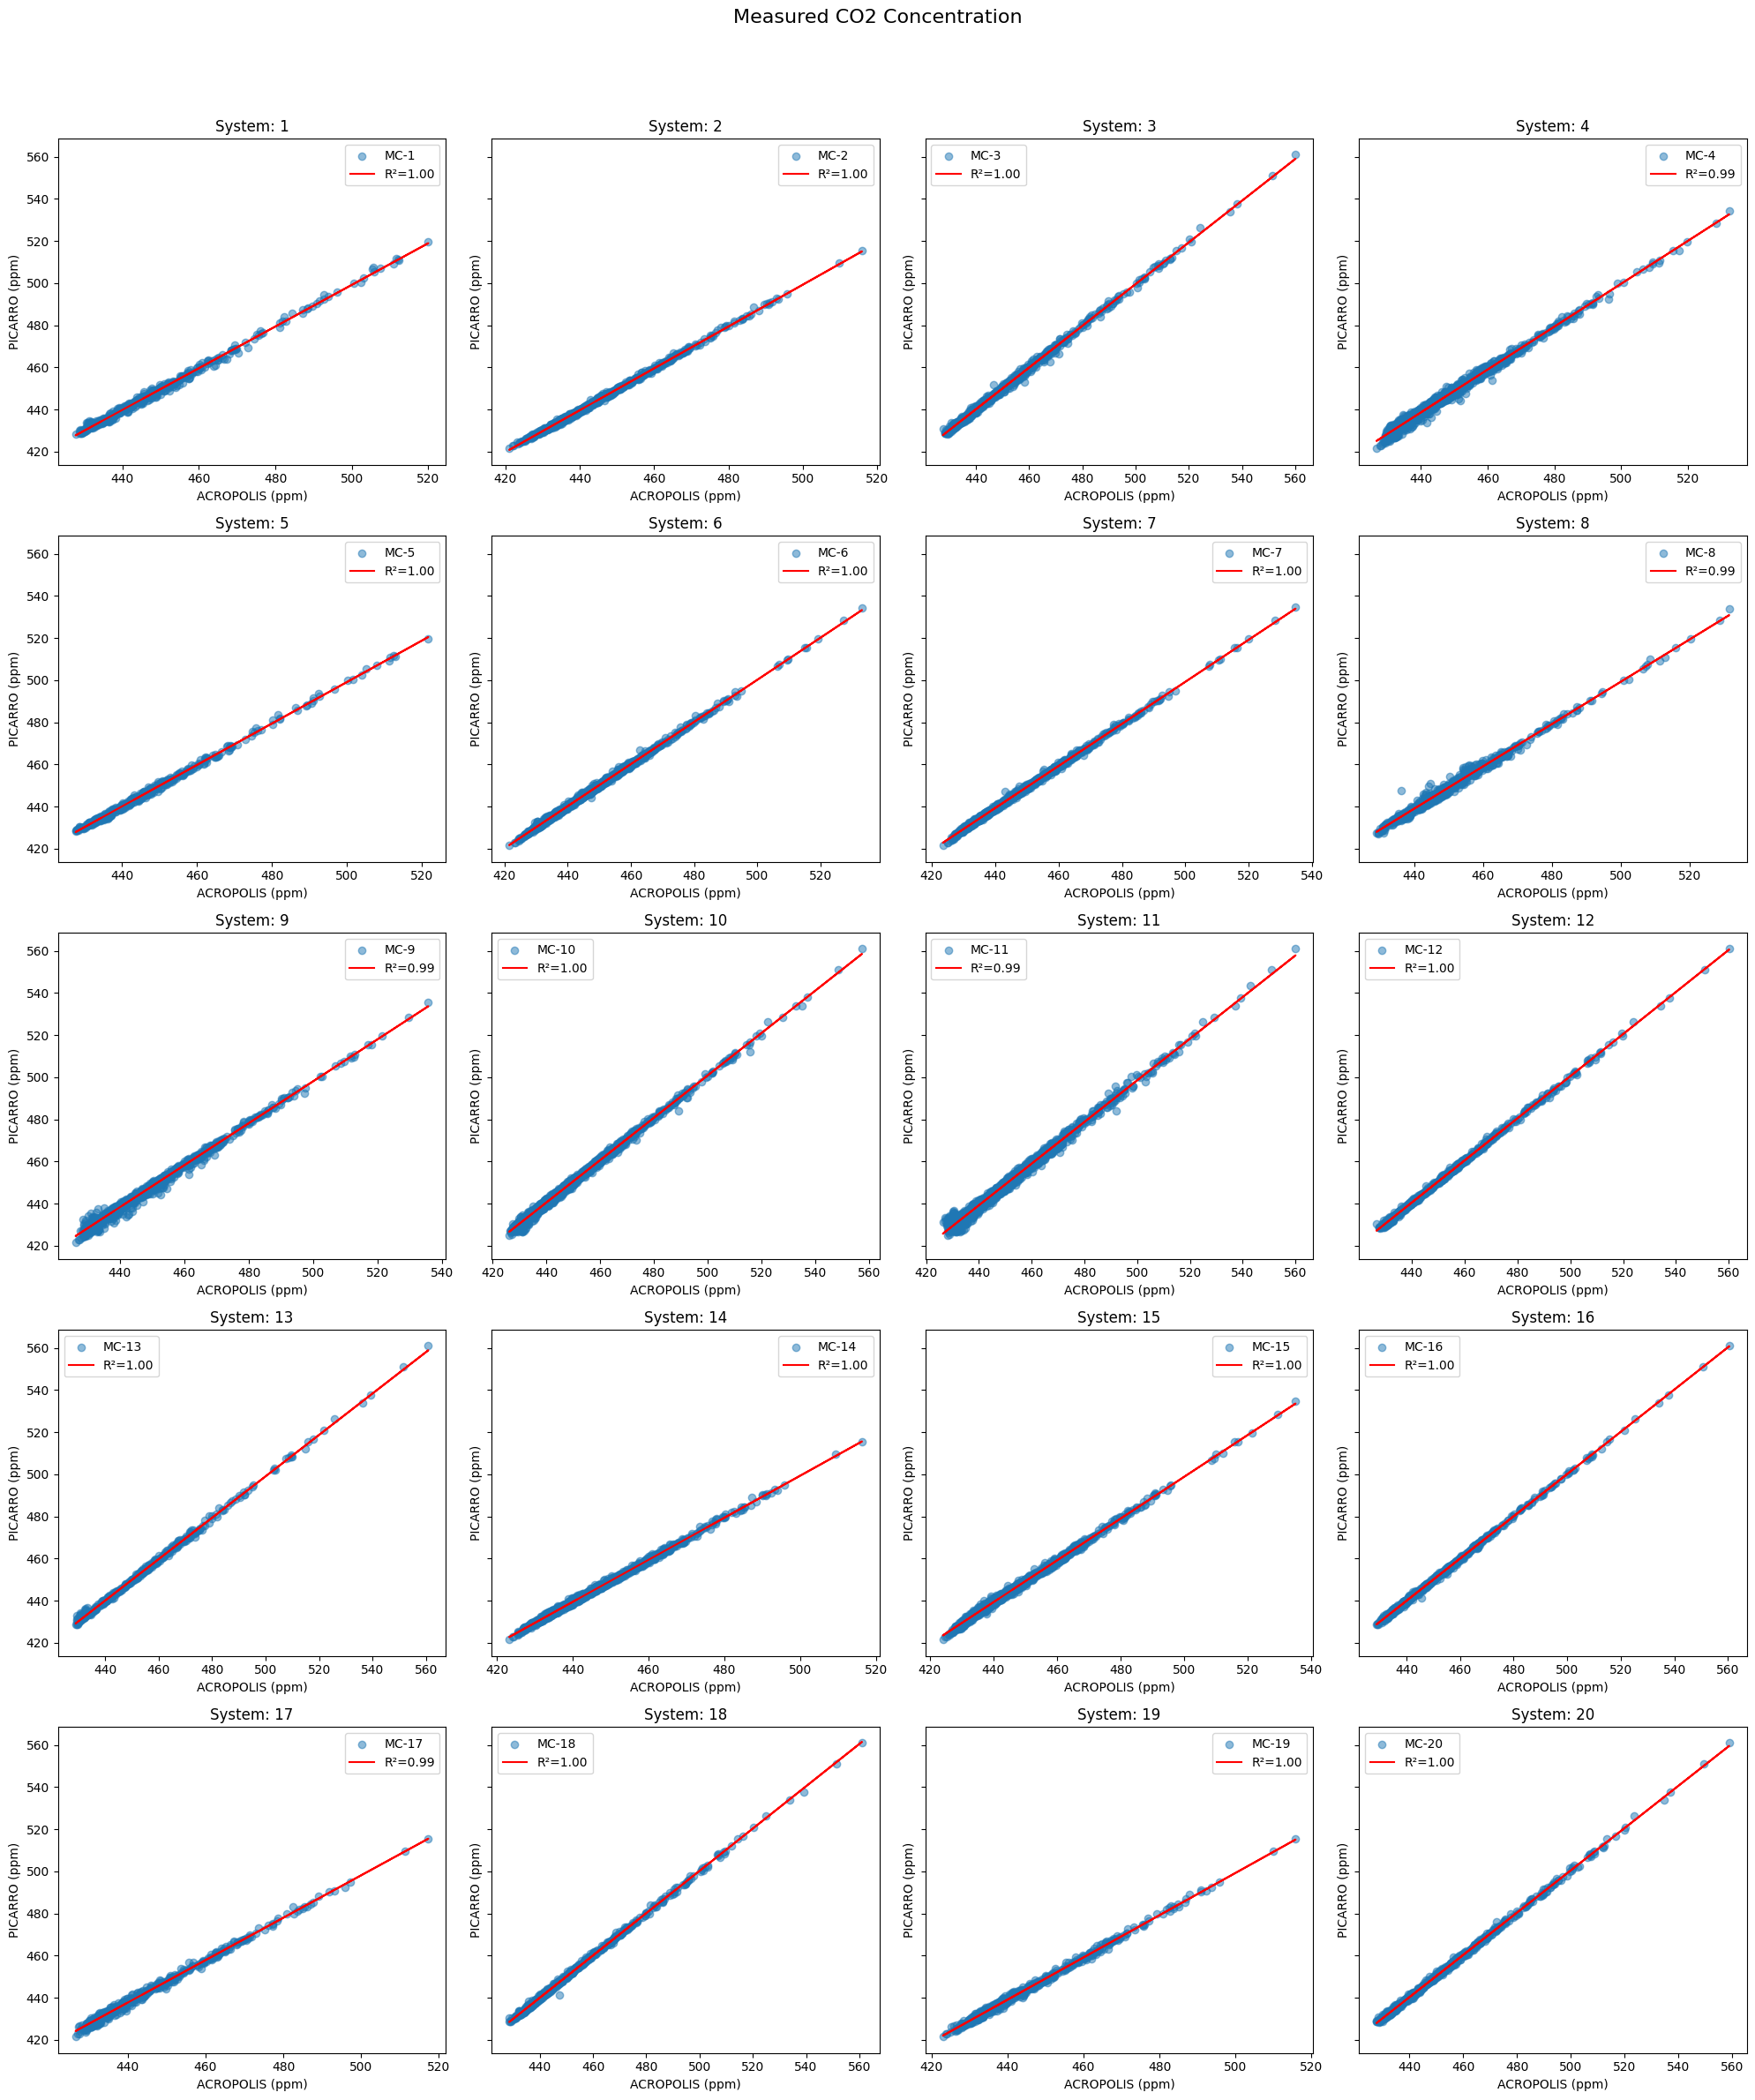

In [6]:
# parameters
x_col_name = "gmp343_corrected"
y_col_name = "picarro_corrected"
max_col = 4
max_row = 5
x_title = "ACROPOLIS (ppm)"
y_title = "PICARRO (ppm)"
title_text = "Measured CO2 Concentration" 

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text=title_text)

In [17]:
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

def plot_scatter_with_trendline(df, x_col_name, y_col_name="diff", max_col=5, max_row=4, x_title="x_name", y_title="CO₂ hourly mean difference (ppm)", title_text="", y_lim=None):
    system_ids = df.select("system_id").unique().to_series().sort().to_list()
    num_systems = len(system_ids)
    
    fig, axes = plt.subplots(max_row, max_col, figsize=(5 * max_col, 5 * max_row), sharey=True)
    #fig.suptitle(title_text, fontsize=16)
    
    axes = np.array(axes).reshape(max_row, max_col)  # Ensure correct shape
    
    for idx, system_id in enumerate(system_ids):
        if idx >= max_row * max_col:
            break
        row, col = divmod(idx, max_col)
        ax = axes[row, col]
        df_plot = df.filter(pl.col("system_id") == system_id)
        
        x = df_plot.select(x_col_name).to_numpy().flatten().reshape(-1, 1)
        y = df_plot.select(y_col_name).to_numpy().flatten().reshape(-1, 1)

        
        xy = np.vstack([x.transpose(), y.transpose()])
        z  = gaussian_kde(xy)(xy)
        idx = z.argsort()           # sort so densest are plotted last
        x, y, z = x[idx], y[idx], z[idx]
        

        sc = ax.scatter(
                x, y,
                c=z,                    # one color per point
                cmap='cividis',         # or any other colormap
                s=25,                   # smaller markers
                edgecolor='black',
                linewidths=0.2, 
                alpha=0.7,
                label=f"n={len(x)}",
            )
        
        # Fit linear regression
        if len(x) > 1:
            model = LinearRegression()
            model.fit(x, y)
            y_pred = model.predict(x)
            
            # Plot trendline
            ax.plot(x, y_pred, color='red')
            ax.plot(x, np.zeros_like(x), color='black', linestyle='--')
            
        if y_lim is not None:
            ax.set_ylim(y_lim)
        
        ax.set_title(f"System: {int(system_id)}")
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        ax.legend()
    
    # Hide unused subplots
    for idx in range(num_systems, max_row * max_col):
        row, col = divmod(idx, max_col)
        fig.delaxes(axes[row, col])
        
        
    # shared legend for regression & baseline
    line_reg  = Line2D([0],[0], color="red",   label='Linear Regression')
    line_base = Line2D([0],[0], linestyle='--', color='black', label='Baseline')
    fig.legend(
        handles=[line_reg, line_base],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        frameon=False,
        fontsize=25,
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

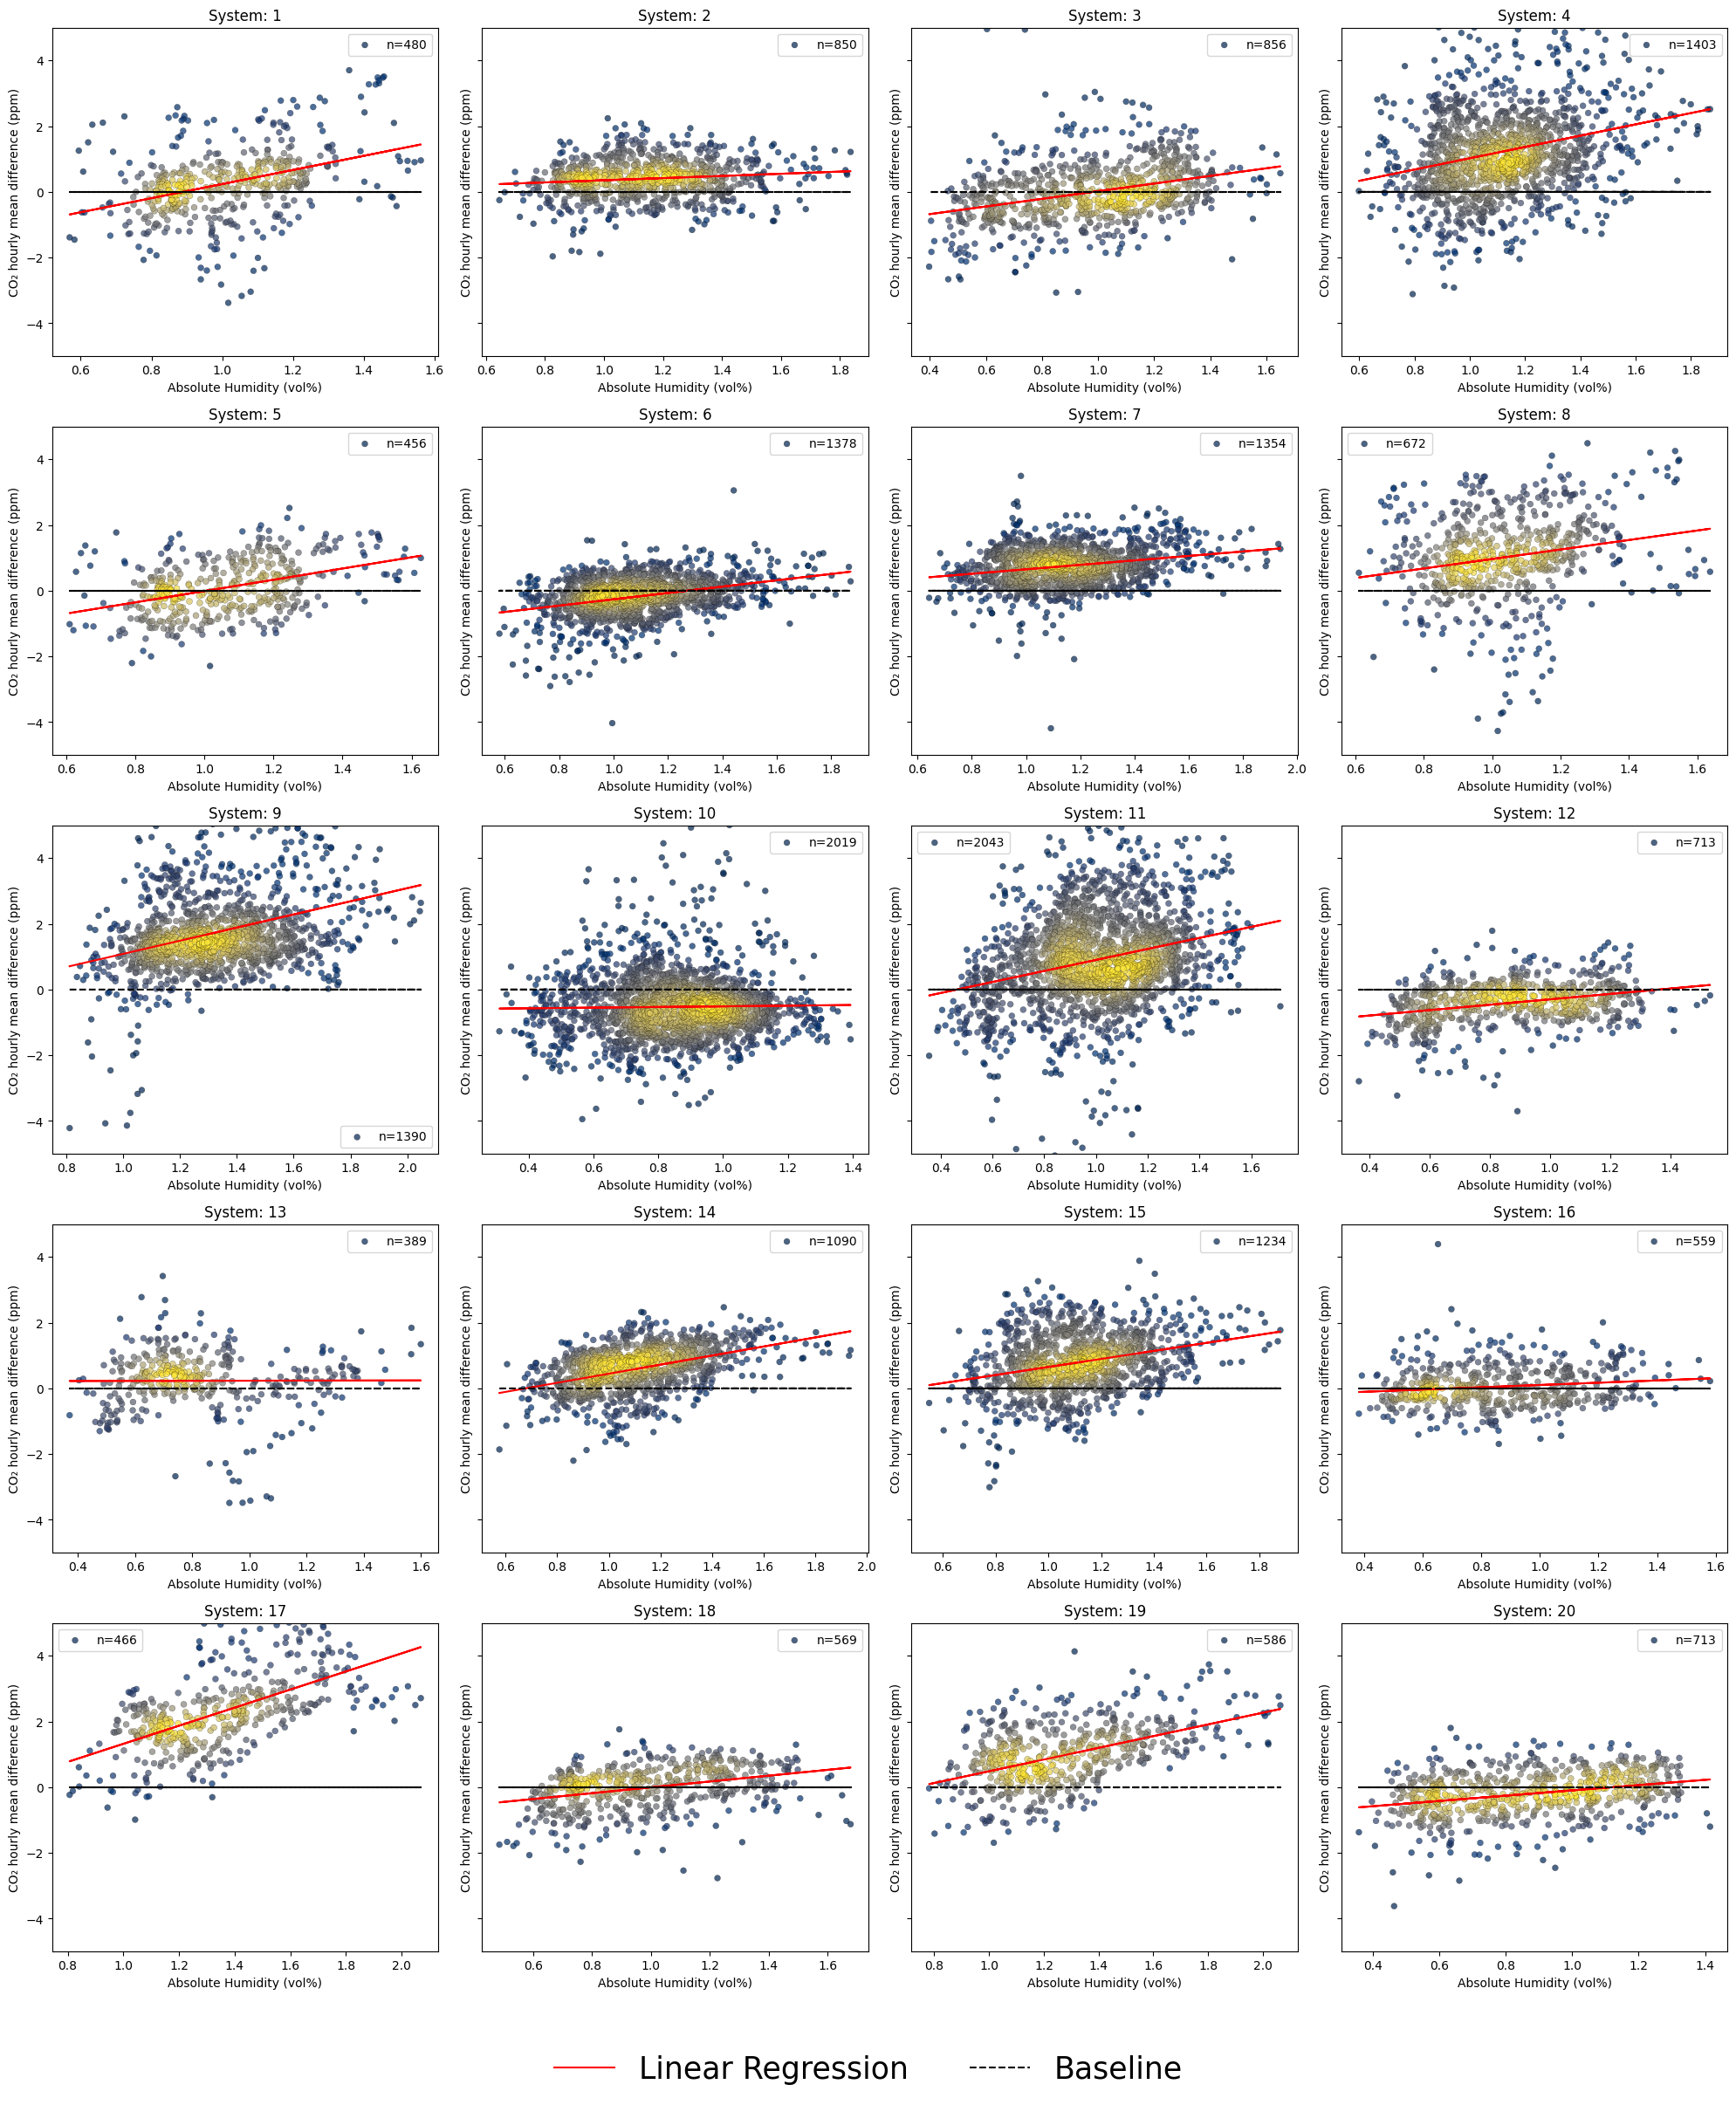

In [18]:
# parameters
x_col_name = "h2o_v%"
y_col_name = "diff"
max_col = 4
max_row = 5
x_title = "Absolute Humidity (vol%)"
y_title = "CO₂ hourly mean difference (ppm)"
title_text = "Scatter Plots: ΔCO2 vs Absolute Humidity" 

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text=title_text, y_lim=(-5, 5))

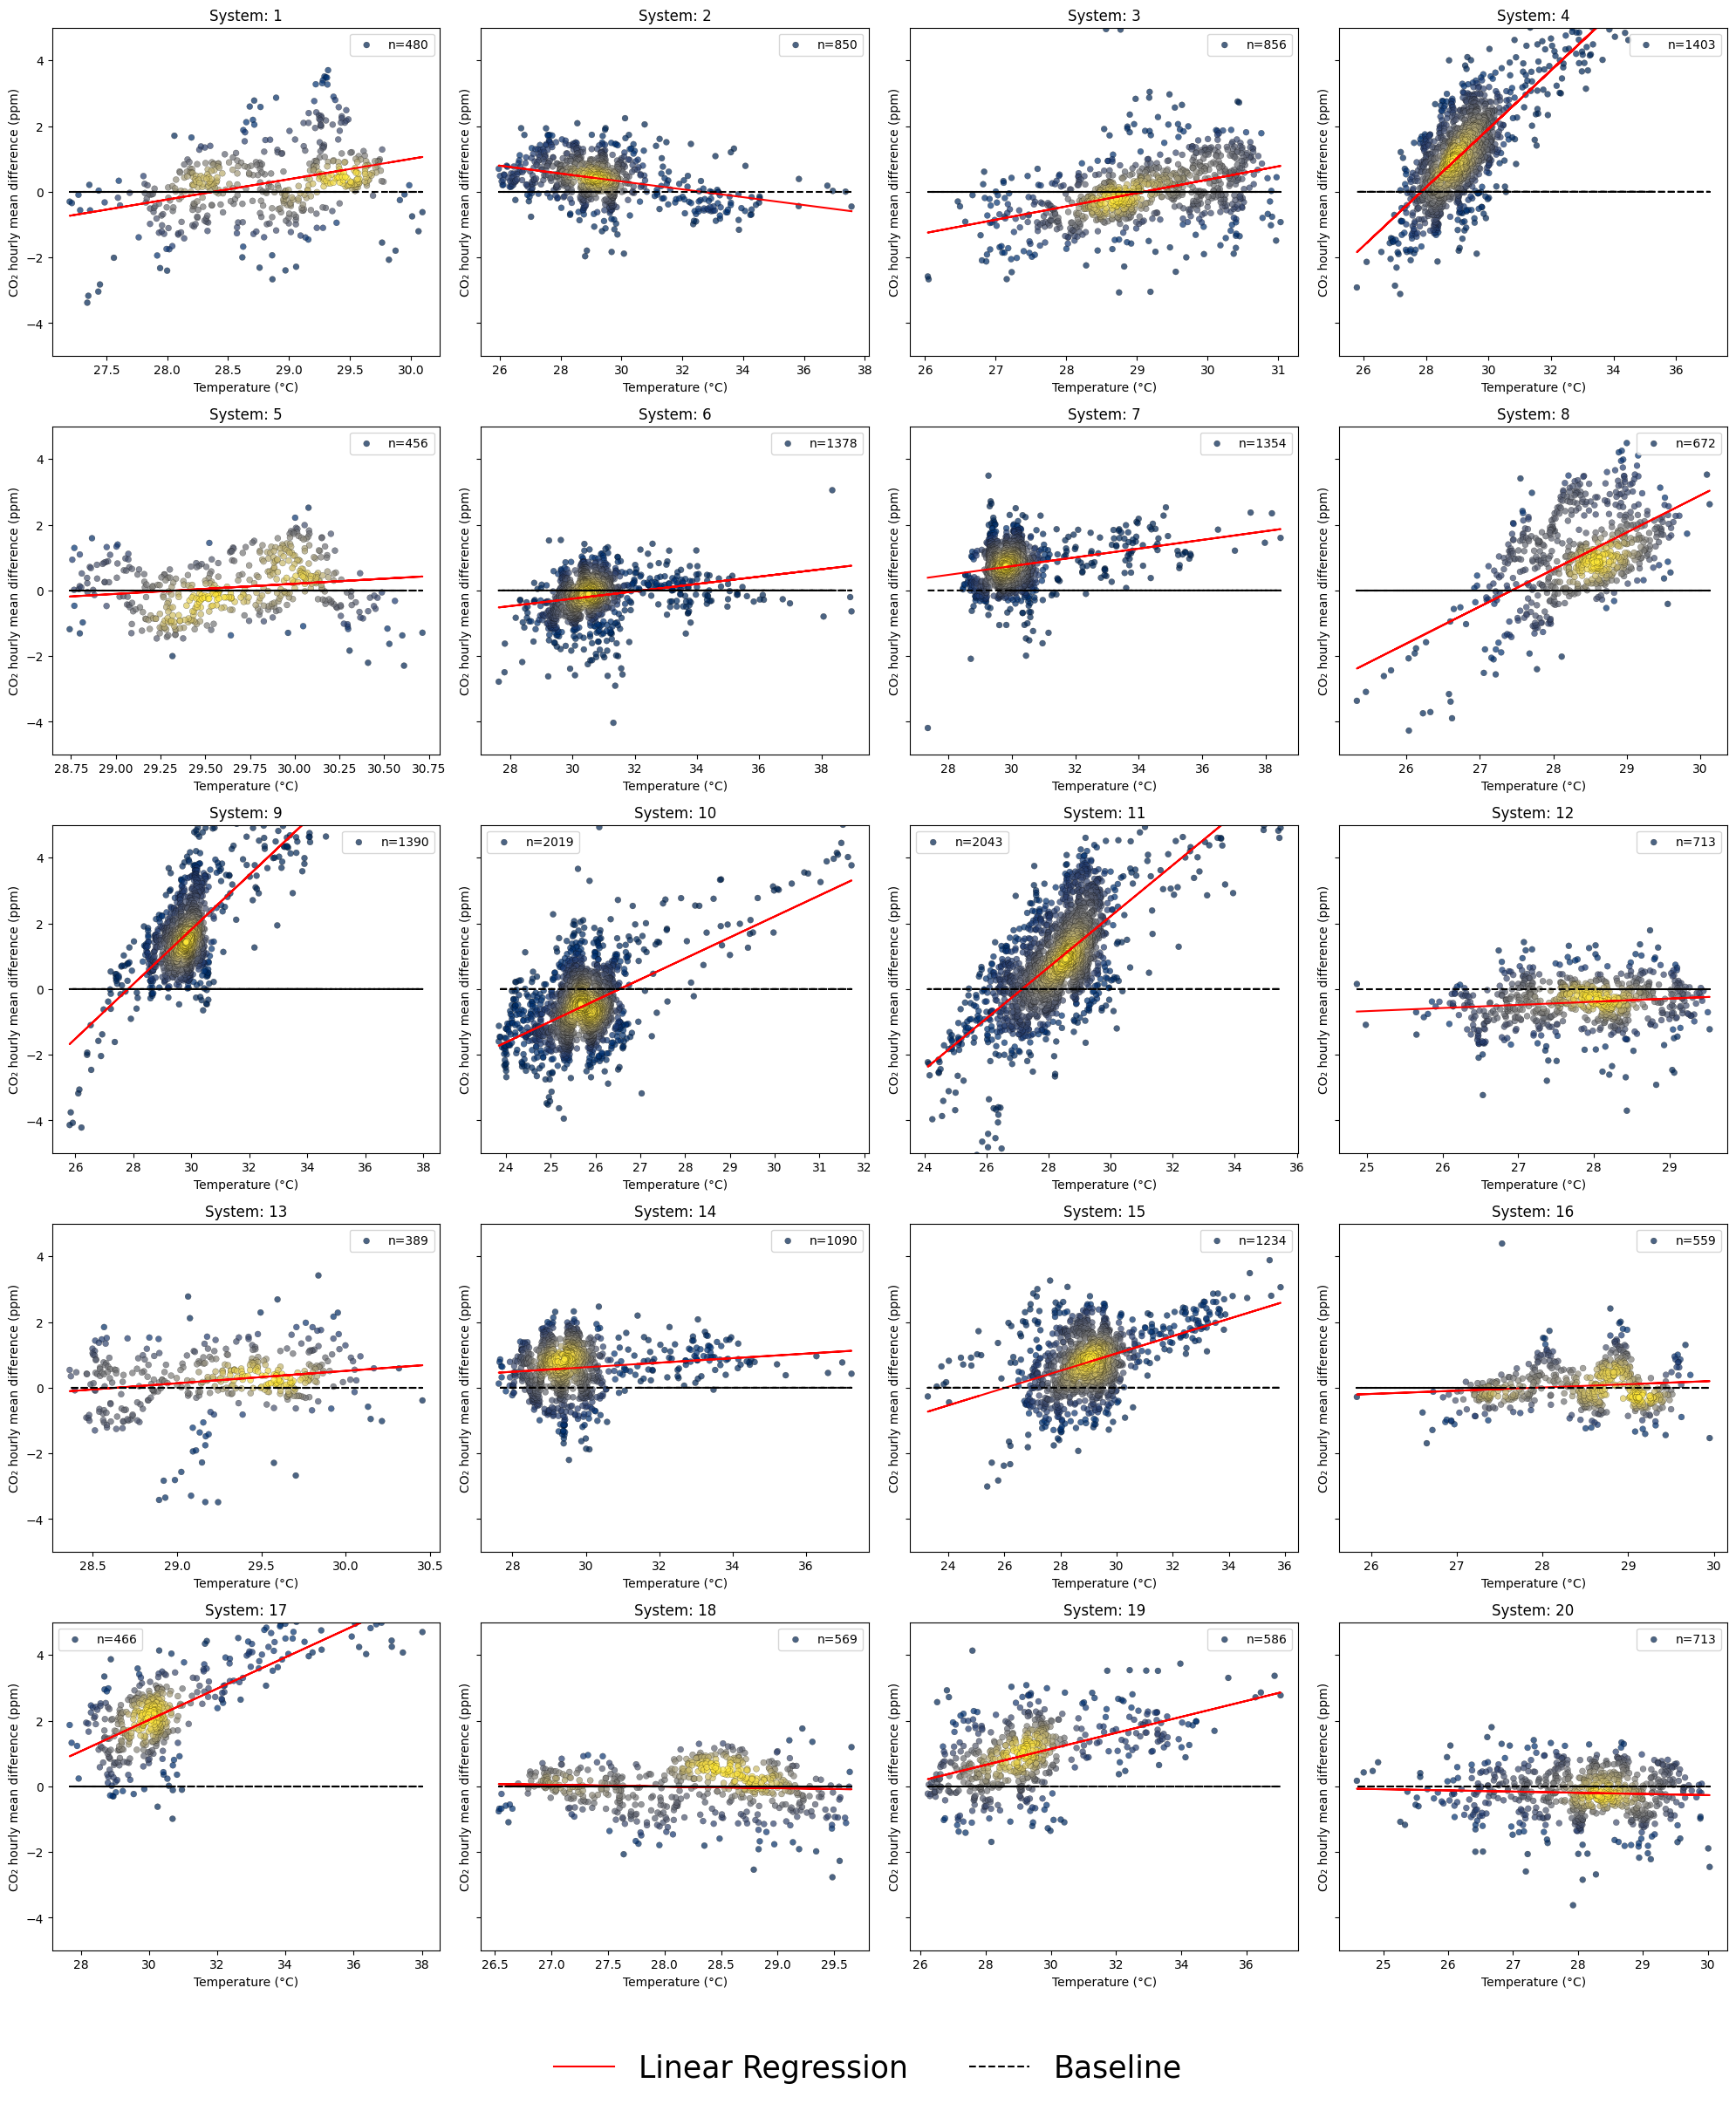

In [19]:
# parameters
x_col_name = "gmp343_temperature"
y_col_name = "diff"
max_col = 4
max_row = 5
y_title = "CO₂ hourly mean difference (ppm)"
x_title = "Temperature (°C)"
title_text = "Scatter Plots: ΔCO2 vs Temperature" 

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text=title_text, y_lim=(-5, 5))

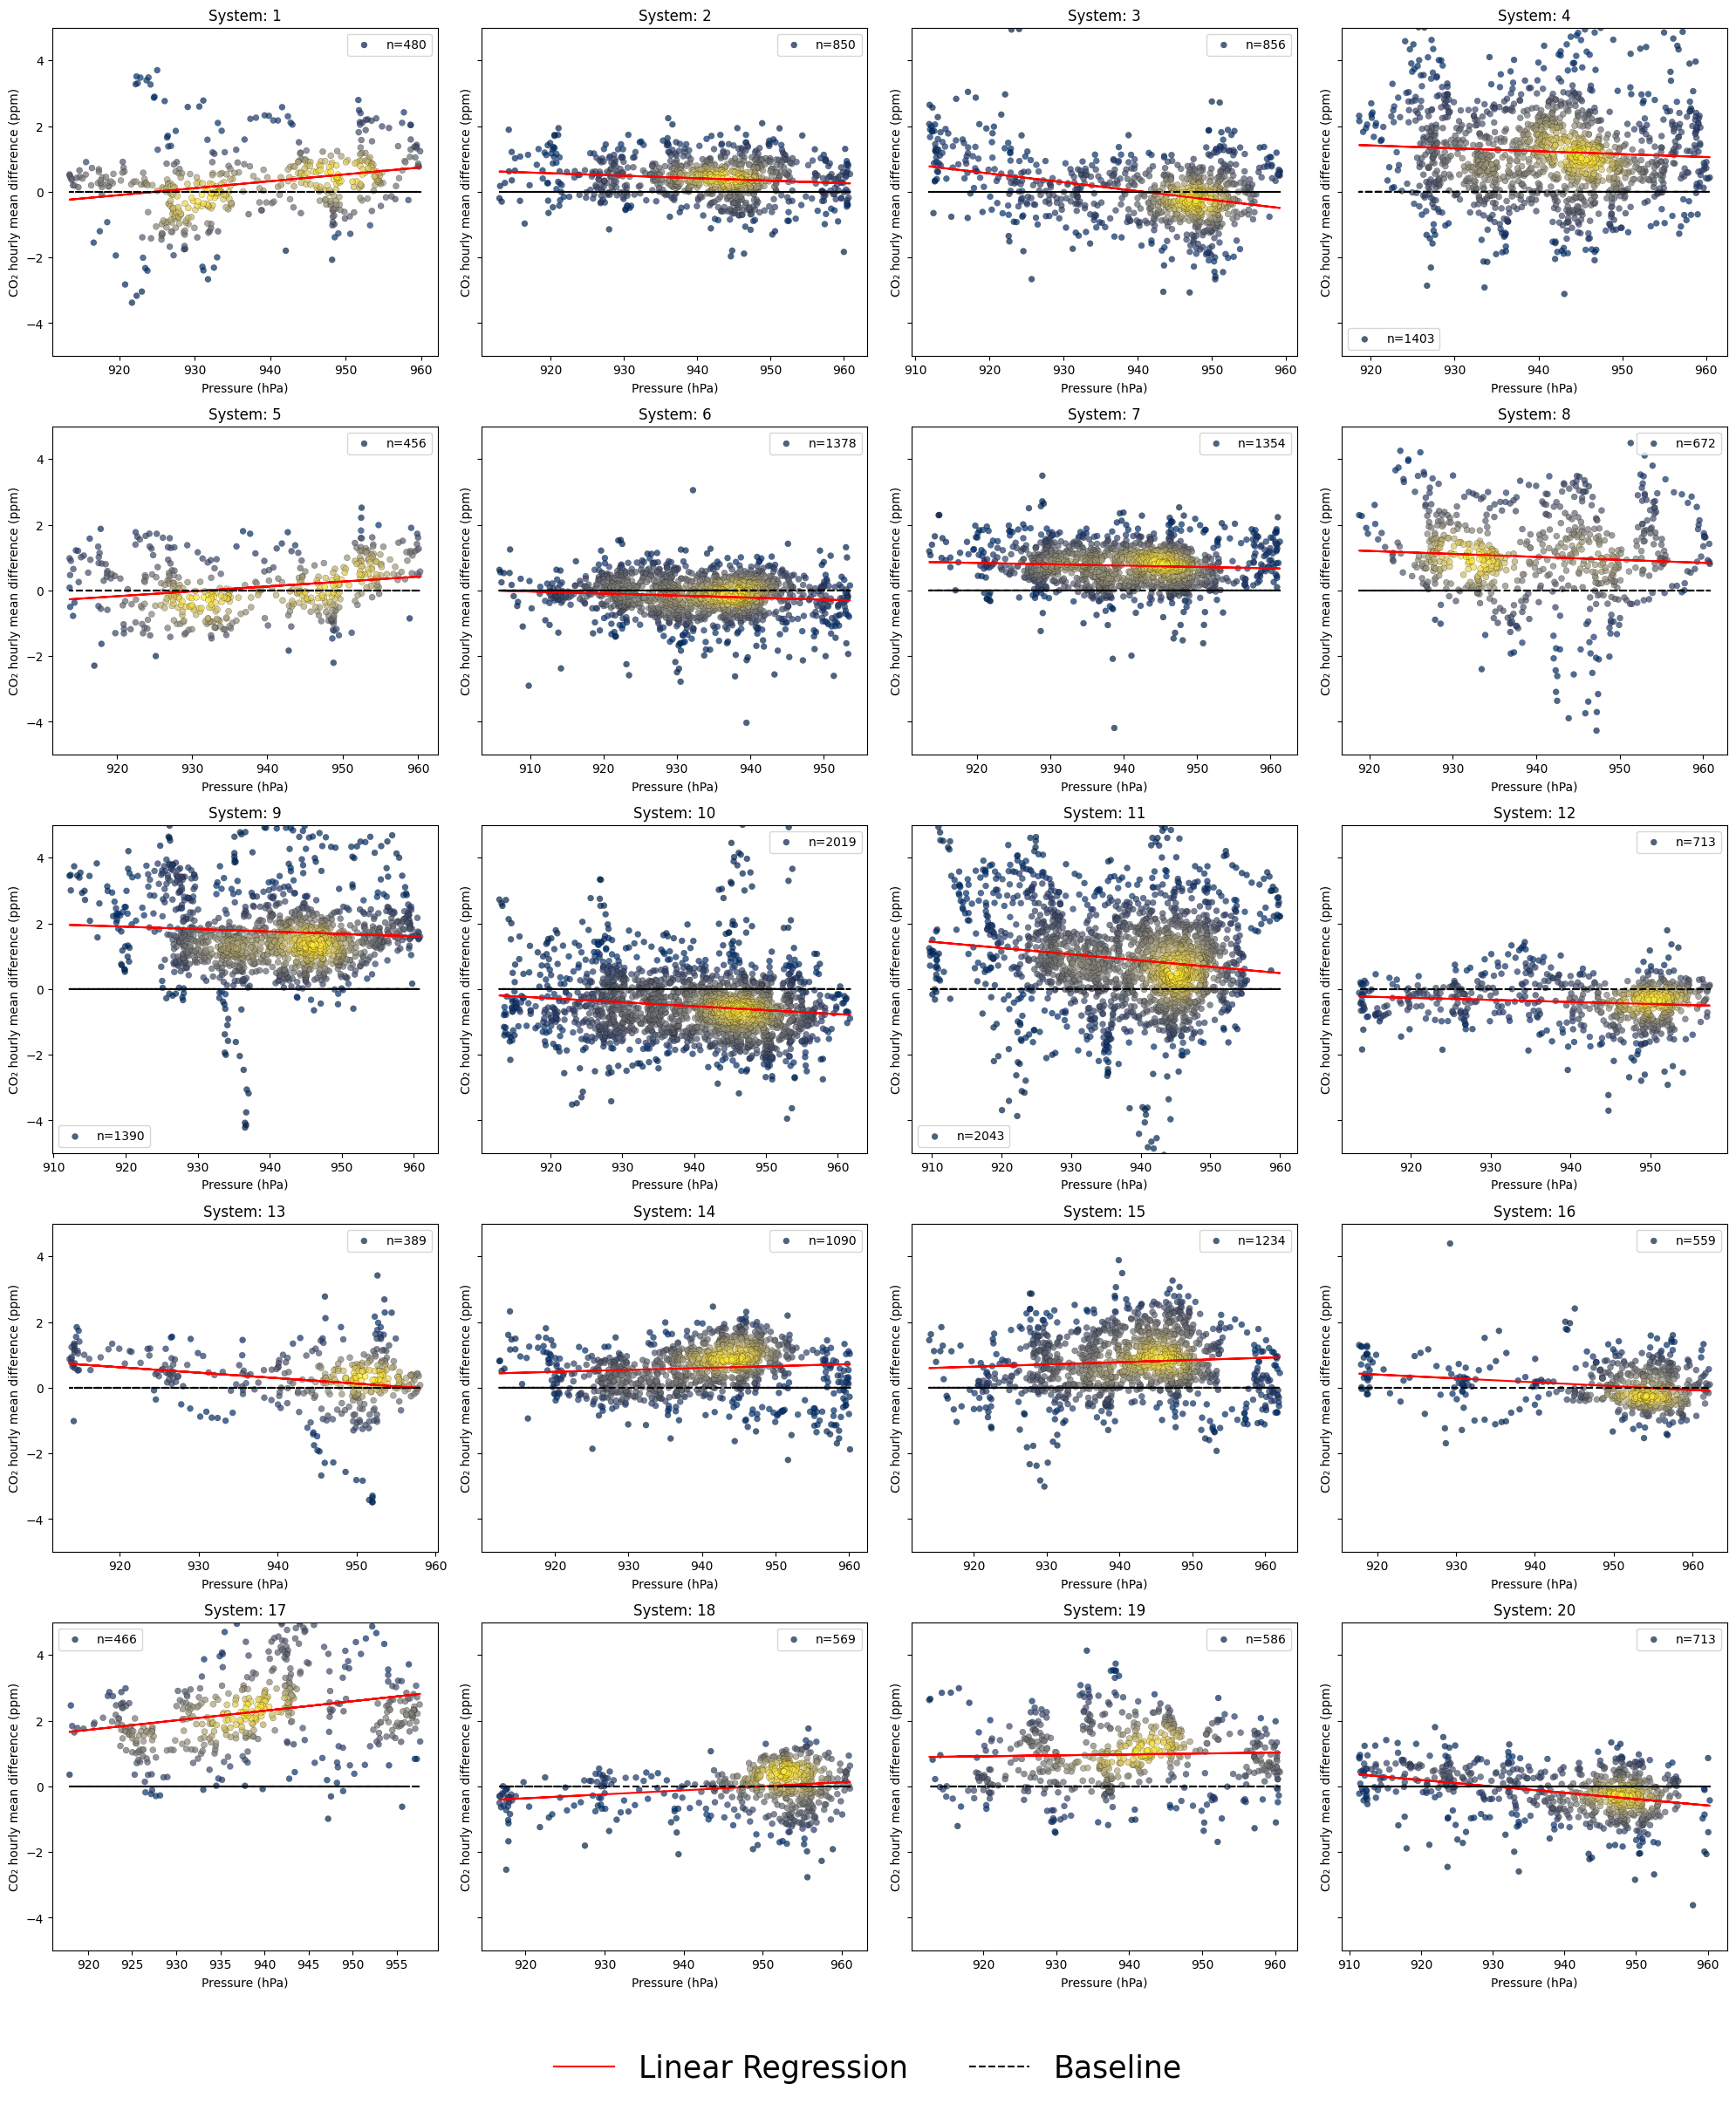

In [20]:
# parameters
x_col_name = "bme280_pressure"
y_col_name = "diff"
max_col = 4
max_row = 5
y_title = "CO₂ hourly mean difference (ppm)"
x_title = "Pressure (hPa)"
title_text = "Scatter Plots: ΔCO2 vs Pressure" 

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text=title_text, y_lim=(-5, 5))